# まとめ
- MNISTでNNの基礎
- ピクセル値の平均を用いたロジスティック回帰で識別をやってみたが難しい
- そこでNN
- NNは活性化関数を備えた全結合層からなる連結ネットワーク
- NNの出力である予測値と正解ラベルの比較スコアを損失関数で計算
    - 一般的な，平均二乗誤差をここでは用いた
- 勾配降下法で最も急な勾配を辿りながら損失関数の最適解を探索
- 確率勾配降下法(SGD)はミニバッチごとに勾配を計算するため高速
    - しかし最適地付近で右往左往しがち
- 微分のチェーンルールに基づく誤差逆伝播法で勾配を効率的に計算

- 人工NNの基礎
- MNIST
- NNの実装

ニューラルネットワークの歴史は1940年代初めに遡る  
  
最小単位ブロックとして，ニューロンを使用する  
ニューロンは層を形成し，互いに接続されてネットワークを結ぶ  
信号が十分に強い時，ニューロンが活性化するといい，値を出力  
入力データが出力層に到達するまで伝搬され，予測を得る  
その予測を期待される出力と比較して誤差を計算し，ネットワークを改善  

ここではMNISTの学習をやってみる  
付録AではPythonによる線形代数(ベクトルテンソルの計算)と微分について  
付録Bでは誤差逆伝搬法について簡単に説明している  
付録Bでは一応式を追う理論的な説明が行われているが，お察しの直訳なのでなんだか雑．ここを詳しく知りたいならもっといい資料がある．

### 手書き数字のMNISTデータセット
[ソースコードとpkl](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/dlgo/nn)  
2次元画像，サイズは784=28\*28，0は白，1は黒  
らしいんだけどこいつは0～255だったのでload時に正規化しとく

### MNISTデータの前処理
0~9のラベルをone-hotエンコーディングする    

In [36]:
import pickle, random, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def encode_label(j):
    """ 0~9のラベルのone-hotエンコーディングを返す """
    e = np.zeros((10, 1))
    e[j] = 1
    return e

def shape_data(data, encode=True):
    """ flatten画像データとラベルのペアをzipで返す """
    features = [np.reshape(x, (784, 1)) / 255 for x in data[0]]
    labels = [encode_label(y) for y in data[1]]
    return zip(features, labels)

def load_data():
    data = np.load("../datasets/mnist/mnist.npz")
    train = shape_data((data['x_train'], data['y_train']))
    test = shape_data((data['x_test'], data['y_test']))
    return np.array(list(train)), np.array(list(test))

In [4]:
train, test = load_data()

この数字を画像から読み取るような問題は，説明できるより多くのことを知っているポラニーのパラドックスという現象で説明され，解決法を明示的に機械に示すのは難しい．

ここはまず，8とラベル付けされたデータ全てで，画素の位置ごとに平均を取ってみる  

In [5]:
def average_digit(data, digit):
    filtered_data = [x[0] for x in data if np.argmax(x[1]) == digit]
    filtered_array = np.asarray(filtered_data)
    return np.average(filtered_array, axis=0)

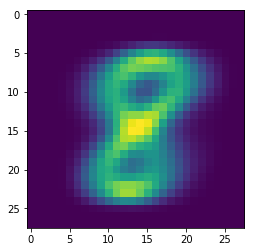

In [6]:
avg_eight = average_digit(train, 8)
img = np.reshape(avg_eight, (28, 28))
plt.imshow(img)
plt.show()

画素ごとの平均でも，8に関してはけっこうしっかり8っぽく見える  
ドット積による類似度計算で，他の画像がどれだけ平均に近いかを見てみる

In [7]:
W = np.transpose(avg_eight)
print(W @ train[2][0]) # ラベルは4
print(W @ train[17][0]) # ラベルは8

[[20.094909]]
[[54.5321651]]


数値が大きいほど被っているところが大きいということ  
なので，正解のラベルの方が数値が大きくなるのが自然

ドット積の出力を0~1の範囲に変換して扱いたい  
そこでシグモイド関数を用いる  
$$ \sigma (x) = \frac{1}{1 + e^{-x}} $$

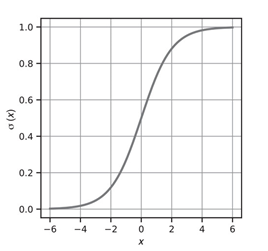

In [8]:
def sigmoid_double(x):
    return 1. / (1. + np.exp(-x))

def sigmoid(z):
    """ ベクトルに対するシグモイド関数の実装 """
    return np.vectorize(sigmoid_double)(z)

このままさっきの値をシグモイドに入れても，同じくらいの出力になってしまう  
そこで，適切なバイアス項を加えることでしっかり区別できるようになる  

In [9]:
def predict(x, W, b):
    return sigmoid_double(W @ x + b)

b = -45
print(predict(train[2][0], W, b))
print(predict(train[17][0], W, b))

[[1.52706108e-11]]
[[0.99992752]]


これより，4に対しては限りなく0，8に対しては限りなく1に近い出力を得られ，区別ができた  
このように，入力ベクトルを$\sigma(Wx+b)$に写像する手順をロジスティック回帰と呼ぶ  
入力サイズが4の時の例を以下に示す

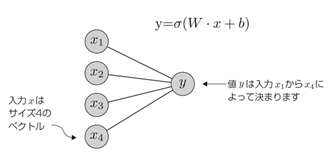

この8の画像の平均によって，どれだけMNISTを識別できるか確かめてみる  
訓練セット，テストセット，テストセットで8のみを扱うセットの正解率を求める

In [10]:
def evaluate(data, digit, threshold, W, b):
    total_samples = 1.0 * len(data)
    correct_predictions = 0
    
    # predictの正解数を数える
    for x in data:
        
        # digitであることを当てた回数 argmaxでonehotから番号をもらってる
        if predict(x[0], W, b) > threshold and np.argmax(x[1]) == digit:
            correct_predictions += 1
        
        # digitでないことを当てた回数
        if predict(x[0], W, b) <= threshold and np.argmax(x[1]) != digit:
            correct_predictions += 1
    
    return correct_predictions / total_samples

In [12]:
train_score = evaluate(data=train, digit=8, threshold=0.5, W=W, b=b)
test_score = evaluate(data=test, digit=8, threshold=0.5, W=W, b=b)

eight_test = [x for x in test if np.argmax(x[1]) == 8]
eight_test_score = evaluate(data=eight_test, digit=8, threshold=0.5, W=W, b=b)

print(f"train: {train_score}")
print(f"test: {test_score}")
print(f"eight test: {eight_test_score}")

train: 0.682
test: 0.6694
eight test: 0.8193018480492813


訓練セットの8の画像の平均を識別に使ったはずなのにeight_testが最大になってる  
これはなんか変だか，train > testにはなっている  
  
この結果は，いかにこの識別方法が汎化，すなわち未知のデータをうまく識別できるかを表している  
  
この結果は未知のサンプルが3つあったら2つしか当たらないことを意味する．  
これをベースラインとするが，最良には程遠い．

このように，ニューラルネットワークを扱わない手法には次のような難点がある  
- 10個の数字全てを正確に予測するモデルを定義する必要がある
- パラメータの数を増やす必要があり，しかも効果的なものが必要  
- データのブレや多様性を捉えるアルゴリズムが必要
- 閾値ではなく，予測値がどれだけ正解に近いかということを考慮したい
- モデルのパラメータを訓練データに応じて更新したい

## ニューラルネットワークの基礎
NNを理解するための基本概念を，以上のモデルを拡張することで紹介

### 単純な人工NNとしてのロジスティック回帰
上記のロジスティック回帰は次の式で表される  
$$ y = \sigma(Wx+b) $$
入力特徴ベクトル$x$は$W$と$b$で$y$に接続されたニューロン(ユニット)と考えられる  
シグモイド関数は入力が1に近ければ活性化する活性化関数と見ることができる  
よってロジスティック回帰はNNの小さな例とみなせる

### 出力次元が複数あるネットワーク
出力$y$を長さ10のベクトルとし，各次元は各数字の尤度とする  
また，  $W: (10, 784)$，$x: (784, 1)$, $b: (10, 1)$とする  
これで，$z: (10, 1)$をシグモイドに入れることで$y: (10, 1)$とする

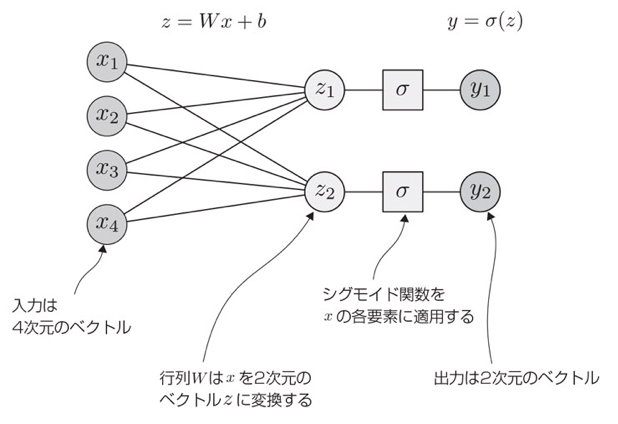

ベクトルからベクトルへの変換を何度も行える，順伝播型ネットワークを構築した

## 順伝播型ネットワーク
$z=Wx+b$すなわちアフィン変換を$\sigma$に通して$y$を得た．  
上記の例は1層のNNと言え，これを複数積み重ねるのが多層NNである．  
つまり，
- $z^1 = W^1 x + b^1$を計算
- $y = W^2 z^1 + b^2$を得る

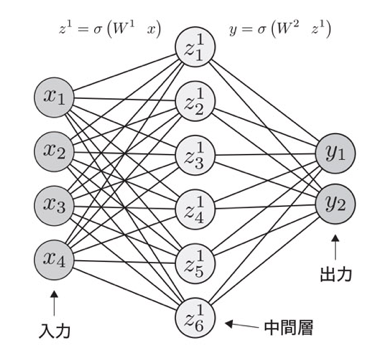

左から右の方向を順方向と言い，順方向に適用を行うことをフォワードパスと言う

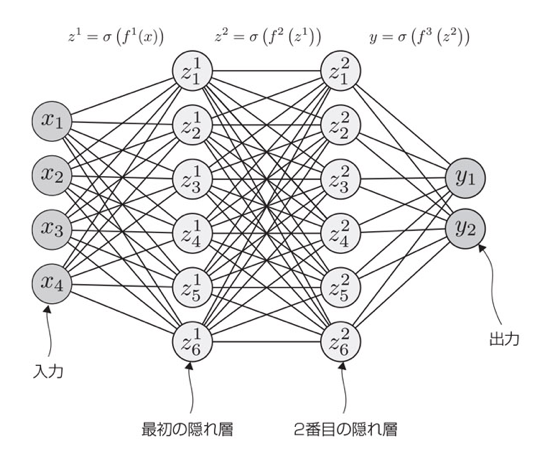
三層にすることもできる

アフィン変換による層の種は全結合層(dense layer)と呼ばれる  
上記のアーキテクチャは多層パーセプトロン(MLP)という  
入力層と出力層(可視ユニット)以外のニューロンは隠れ層の隠れユニットと呼ぶ  
このように多くの隠れ層を持つNNを深層NN，深層学習と呼ぶ．  
  
本書ではシーケンシャルなNNを扱うが，非シーケンシャルなNNもある

## 予測精度はどれくらいか？損失関数と最適化
予測が正解の値にどれくらい近いかを定義する尺度を定義

### 損失関数(目的関数)とは何か
予測がどれだけ目的を達成できなかったかを定量化する微分可能な関数  
$$ \sum_i \rm{Loss}(W, b, X_i, \hat{y_i}) = \sum_i \rm{Loss}(y_i, \hat{y_i}) \in R_+ $$
ここで，$X_i$は入力特徴量の集合，$\hat{y_i}$は正解ラベルである  
この損失関数を最小化することが訓練の目的になる

### 平均二乗誤差(mean squared error, MSE)
広く使われている損失関数の一つ．  
$$ MSE(y, \hat{y}) = \frac{1}{2} \sum_{i=1}^k (y_i - \hat{y_i})^2 $$

In [46]:
class MSE():
    def __init__(self):
        pass
    
    @staticmethod
    def loss_function(self, predictions, labels):
        """ MSEの値を求める """
        diff = predictions - labels
        return 0.5 * sum(diff * diff)[0]
    
    @staticmethod
    def loss_derivative(predictions, labels):
        """ MSEの微分, ベクトルを返す """
        return (predictions - labels)

### 損失関数の極小値を求める
微分して0の点が損失関数の最小値になる  
微分を計算し，特定の点で評価することを勾配計算という  

#### 極小値を見つけるための勾配降下法
損失関数の最小値を求める勾配降下アルゴリズム  
1. $W$に対するLossの勾配$\Delta$をLossの微分で計算
1. $\alpha\Delta$を減算して$W$を更新，つまり最も急な勾配に沿って下降  
    $\alpha$は学習率
1. 以上を$\Delta$が収束もしくは定義ステップ，定義時間が来るまで繰り返す

局所最適解に陥ることがあることに注意  
しかし，しばしば満足のいく結果に繋がるので無視されることもある

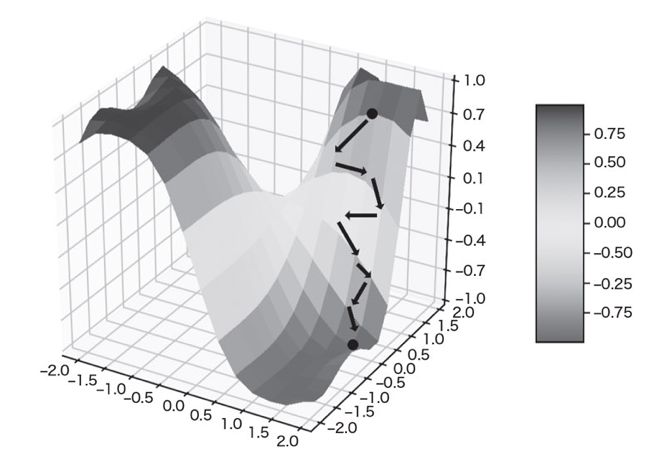

#### 損失関数の確率的勾配降下法(SGD)
全データに対する勾配計算には時間がかかるので，小さな単位ごとに計算したい  
SGDでは訓練セットから複数サンプルをランダムに選ぶ，ミニバッチ単位で訓練  
各ラベルがミニバッチに現れるようラベルの数と同じ桁数にするといいらしい

ミニバッチに対する損失から勾配$\Delta$を求め，パラメータを以下で更新
$$ W^i \leftarrow W^i - \alpha \sum_{j=1}^k \Delta_j W^i $$
$$ b^i \leftarrow b^i - \alpha \sum_{j=1}^k \Delta_j b^i $$
ここで$ \alpha > 0$はハイパーパラメータである学習率

SGDでは，全データの中から一部をランダムに選んで勾配を求めているため，本当に損失関数の最小値に最も近く方向へ進むとは限らない．  
これが原因で極所最適地に近づく前に右往左往する

SGDのようなパラメータの更新ルールは他にもあり，オプティマイザと呼ばれる

### ネットワークへの勾配の逆伝播
微分のチェーンルールを使った誤差逆伝播法により，各層のパラメータ更新を後方から逐次的に効率的に更新できる

ここまでの流れをまとめる
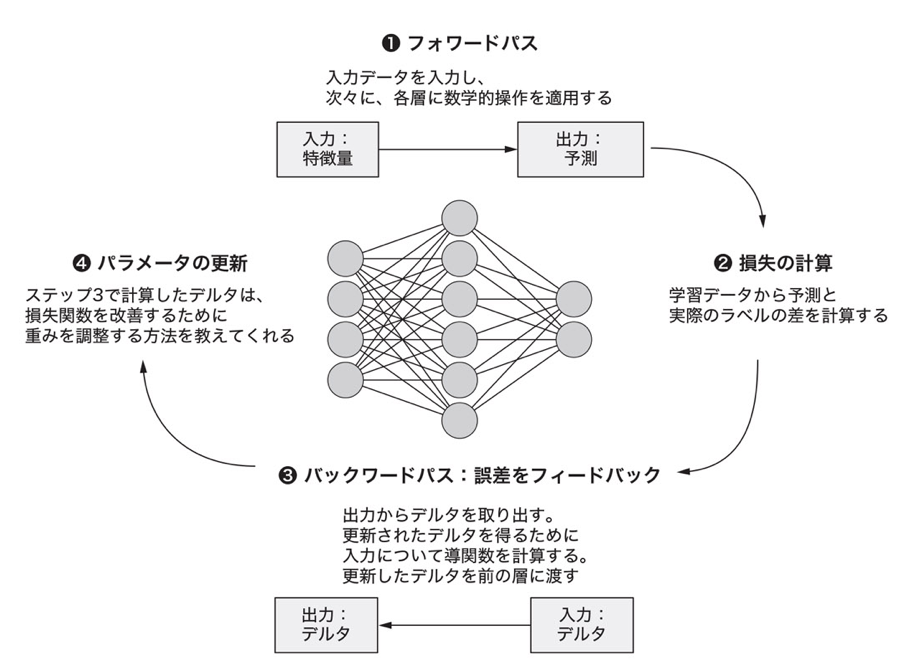

## Pythonを使いNNを作る

- いくつかのLayerクラス
    - 誤差逆伝播で順伝播の結果を使うので保持しておく
- SequentialNetworkクラス
- Lossクラス

In [55]:
class Layer(object): 
    def __init__(self):
        self.params = []
        self.previous = None
        self.next = None
        
        self.input_data = None
        self.output_data = None
        
        self.input_data = None
        self.output_data = None
        
    def connect(self, layer):
        """ layerの次の層としてこの層を結合 """
        self.previous = layer
        layer.next = self
    
    def forward(self):
        """ 入力データの順伝播 """
        raise NotImplementedError
        
    def get_forward_input(self):
        """ 順伝播におけるこの層への入力データを返す """
        if self.previous != None:
            # 一つ前の層の出力
            return self.previous.output_data
        else:
            # 最初の層
            return self.input_data
    
    def backward(self):
        """ 誤差逆伝播 """
        raise NotImplementedError
    
    def get_backward_input(self):
        """ 逆伝播におけるこの層への入力データを返す， つまり次の層の出力 """
        if self.next != None:
            return self.next.output_delta
        else:
            return self.input_delta
    
    def clear_deltas(self):
        """ デルタのリセット """
        pass
    
    def update_params(self, learning_rate):
        """ learning_rateを指定してパラメータの更新 """
        pass

    def describe(self):
        """ プロパティの出力 """
        raise NotImplementedError

### ニューラルネットワークにおける活性化層
まずはシグモイド関数の微分を実装

In [56]:
def sigmoid_prime_double(x):
    return sigmoid_double(x) * (1 - sigmoid_double(x))

def sigmoid_prime(z):
    return np.vectorize(sigmoid_prime_double)(z)

シグモイド活性化層を実装  
パラメータを持たないことに注意

In [57]:
class ActivationLayer(Layer):
    def __init__(self, input_dim):
        super(ActivationLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = input_dim
        
    def forward(self):
        """ 順方向は入力データにシグモイドを適用するだけ """
        data = self.get_forward_input()
        self.output_data = sigmoid(data)
    
    def backward(self):
        """ 逆方向はシグモイド関数の微分とやってきた勾配の積をとるb"""
        delta = self.get_backward_input()
        data = self.get_forward_input()
        self.output_delta = delta * sigmoid_prime(data)
    
    def describe(self):
        print(f"|-- {self.__class__.__name__}")
        print(f"  |-- dimensions: ({self.input_dim}, {self.output_dim})")

### 全結合層
バイアス項，重み行列を扱い，それぞれ勾配を考慮する必要がある  
パラメータの初期化法は結果と収束速度に影響を与え，6章で他にも述べる

In [58]:
class DenseLayer(Layer):
    def __init__(self, input_dim, output_dim):
        super(DenseLayer, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # 乱数で重みとバイアスを初期化し，インスタンスで保持
        self.weight = np.random.randn(output_dim, input_dim)
        self.bias = np.random.randn(output_dim, 1)
        self.params = [self.weight, self.bias]
        
        # 誤差も初期化
        self.delta_w = np.zeros(self.weight.shape)
        self.delta_b = np.zeros(self.bias.shape)
    
    def forward(self):
        """ アフィン線形変換による全結合層の順伝播 """
        data = self.get_forward_input()
        self.output_data = self.weight @ data + self.bias
        
    def backward(self):
        """ 全結合の逆伝播 """
        data = self.get_forward_input()
        delta = self.get_backward_input()
        
        # オプティマイズに使う勾配を保持しておく
        self.delta_b += delta
        self.delta_w += delta @ data.transpose()
        
        # Wの転置を,やってきた誤差にかけて次へ送る
        self.output_delta  = self.weight.transpose() @ delta
    
    def update_params(self, rate):
        """ 保持しておいた勾配を使ったパラメータの更新 """
        self.weight -= rate * self.delta_w
        self.bias -= rate * self.delta_b
        
    def clear_deltas(self):
        """ パラメータ更新後は，デルタをリセット """
        self.delta_w = np.zeros(self.weight.shape)
        self.delta_b = np.zeros(self.bias.shape)
    
    def describe(self):
        print("|--", self.__class__.__name__)
        print(f"  |-- dimensions: ({self.input_dim}, {self.output_dim})")

### シーケンシャルNN
層を結合して保持するシーケンシャルNNを作成

In [62]:
class SequentialNetwork():
    def __init__(self, loss=MSE()):
        print("Initialize Network...")
        self.layers = []
        self.loss = loss
    
    def add(self, layer):
        """ 層をリストに追加，自動で結合 """
        self.layers.append(layer)
        layer.describe()
        if len(self.layers) > 1:
            self.layers[-1].connect(self.layers[-2])
    
    def train(self, 
              training_data, 
              epochs, 
              mini_batch_size, 
              learning_rate,
              test_data=None
            ):
        
        """ 訓練データを与えてNNの学習を行う """
        
        n = len(training_data)
        for epoch in range(epochs):
            random.shuffle(training_data)
            
            # 訓練データをミニバッチに分割
            mini_batches = [
                training_data[k:k+mini_batch_size] \
                for k in range(0, n, mini_batch_size)
            ]
            
            # ミニバッチごとに訓練を行う
            for mini_batch in mini_batches:
                self.train_batch(mini_batch, learning_rate)
            
            # テスト用データが与えられていればそれでエポック完了時点のモデルを評価
            if test_data is None:
                print(f"Epoch {epoch} complete")                
            else:
                n_test = len(test_data)
                print(f"Epoch {epoch}: {self.evaluate(test_data)} / {n_test}")
    
    def train_batch(self, mini_batch, learning_rate):
        self.forward_backward(mini_batch)
        self.update(mini_batch, learning_rate)
        
    def update(self, mini_batch, learning_rate):
        """ モデルの勾配を使ってパラメータを更新 """
        # 一般的に，学習率はミニバッチのサイズで正規化される
        learning_rate = learning_rate / len(mini_batch)
        
        # 勾配情報と求めた学習率を使ってモデルのパラメータを更新
        for layer in self.layers:
            layer.update_params(learning_rate)
        
        # 次のミニバッチ学習を行う前に誤差をリセット
        for layer in self.layers:
            layer.clear_deltas()
    
    def forward_backward(self, mini_batch):
        """ ミニバッチに対する順伝播→逆伝播 """
        for x, y in mini_batch:
            
            # モデルへの入力データをセット
            self.layers[0].input_data = x
            
            # 各層に渡る順伝播を行う
            for layer in self.layers:
                layer.forward()
            
            # 出力結果と比較して損失関数の値を求め，それを損失側にセット
            self.layers[-1].input_delta = \
                self.loss.loss_derivative(self.layers[-1].output_data, y)
            
            # 各層に渡る逆伝播を行い，各層で勾配を求め保持する
            for layer in reversed(self.layers):
                layer.backward()
                
    def single_forward(self, x):
        """ 順伝播による推論のみを行う """
        self.layers[0].input_data = x
        for layer in self.layers:
            layer.forward()
        return self.layers[-1].output_data
    
    def evaluate(self, test_data):
        """ モデルの推論結果が，いくつ当たっているかという評価を返す """
        test_results = [(
            np.argmax(self.single_forward(x)),
            np.argmax(y)
        ) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

### ネットワークを手書き数字分類へ適用
層の数や学習率といったネットワークのハイパーパラメータを設定し，実行  
入力画像のピクセルを半分半分にしていくような3層NN

In [52]:
training, test = load_data()

In [63]:
net = SequentialNetwork()
net.add(DenseLayer(784, 392))
net.add(ActivationLayer(392))
net.add(DenseLayer(392, 196))
net.add(ActivationLayer(196))
net.add(DenseLayer(196, 10))
net.add(ActivationLayer(10))

Initialize Network...
|-- DenseLayer
  |-- dimensions: (784, 392)
|-- ActivationLayer
  |-- dimensions: (392, 392)
|-- DenseLayer
  |-- dimensions: (392, 196)
|-- ActivationLayer
  |-- dimensions: (196, 196)
|-- DenseLayer
  |-- dimensions: (196, 10)
|-- ActivationLayer
  |-- dimensions: (10, 10)


In [ ]:
net.train(
    training, epochs=10, 
    mini_batch_size=10,
    learning_rate=3.0,
    test_data=test
)

結果，10エポック以下で95%ほどの精度を出している  
ベースラインと比較したら，大きな進歩である  
次章では囲碁の話に入る前に畳み込みNNについて述べる

試しに何かを推論してみる

In [ ]:
PKL_PATH = "../datasets/mnist/dlgo_seq_net.pkl"
with open(PKL_PATH, mode="wb") as f:
    pickle.dump(net, f)

In [ ]:
with open(PKL_PATH, mode="rb") as f:
    net = pickle.load(f)

In [45]:
sample = test[np.random.randint(len(test))]
result = np.argmax(net.single_forward(sample))
print(f"This image is predicted as {result}")
plt.plot(sample)
plt.show()

10000